In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, Input
import nengo
import nengo_dl
# https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/keras-to-snn.ipynb#scrollTo=ICv7sPqw6hO6

In [3]:
batch_size = 200
epochs = 2
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
class_count = 10

# # slice amount of training data for ram
# x_train = x_train[0:x_train.shape[0] // 2, : ,:]
# y_train = y_train[0:y_train.shape[0] // 2]

# reshape data - add extra time dimension
x_train = x_train.reshape((x_train.shape[0], 1, -1))
y_train = y_train.reshape((y_train.shape[0], 1, -1))
x_test = x_test.reshape((x_test.shape[0], 1, -1))
y_test = y_test.reshape((y_test.shape[0], 1, -1))

# create a simple CNN
input_layer = Input(shape=(28, 28, 1))
conv1 = Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(input_layer)
conv2 = Conv2D(filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)(conv1)
flatten = Flatten()(conv2)
dense = Dense(128, activation='relu')(flatten)
output_layer = Dense(class_count)(dense)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

converter = nengo_dl.Converter(model)
with nengo_dl.Simulator(converter.net, minibatch_size=batch_size) as simulator:
    simulator.compile(optimizer=tf.optimizers.RMSprop(.001),
                      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[tf.metrics.sparse_categorical_accuracy])

    simulator.fit(
        { converter.inputs[input_layer]: x_train },
        { converter.outputs[output_layer]: y_train },
        validation_data=(
            { converter.inputs[input_layer]: x_test },
            { converter.outputs[output_layer]: y_test }
        ),
        epochs=epochs

    )

    # save the parameters to file
    params_folder = os.path.join('..','snn-params')
    os.makedirs(params_folder, exist_ok=True)
    params_file = os.path.join(params_folder, 'keras_snn_params')
    simulator.save_params(params_file)
    print('param files saved')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/2
300/300 [==============================] - 11s 38ms/step - loss: 0.7926 - probe_loss: 0.7926 - probe_sparse_categorical_accuracy: 0.9359 - val_loss: 0.0735 - val_probe_loss: 0.0735 - val_probe_sparse_categorical_accuracy: 0.9769

In [4]:
# define "function" to run network as ANN / SNN
def run_network(activation, params_file=os.path.join('..', 'snn-params', 'keras_snn_params'), n_steps=30,
                scale_firing_rates=1, synapse=None, n_test=400):

    nengo_converter = nengo_dl.Converter(
        model, swap_activations= { tf.nn.relu: activation },
        scale_firing_rates=scale_firing_rates, synapse=synapse
    )

    # get input and output layers
    nengo_input = nengo_converter.inputs[input_layer]
    nengo_output = nengo_converter.outputs[output_layer]

    # create nengo probe to conv layers to record activity
    sample_neurons_conv1 = np.linspace(0, np.prod(conv1.shape[1:]), 1000, endpoint=False, dtype=np.int32)
    sample_neurons_conv2 = np.linspace(0, np.prod(conv2.shape[1:]), 1000, endpoint=False, dtype=np.int32)

    with nengo_converter.net:
        conv1_probe = nengo.Probe(nengo_converter.layers[conv1][sample_neurons_conv1])
        conv2_probe = nengo.Probe(nengo_converter.layers[conv2][sample_neurons_conv2])

    # repeat inputs for number of time steps
    tiled_x_test = np.tile(x_test[:n_test], (1, n_steps, 1))

    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    with nengo_dl.Simulator(nengo_converter.net, minibatch_size=10, progress_bar=False) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_x_test})

    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == y_test[:n_test, 0, 0]).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    # plot the results
    for i in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(x_test[i, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        scaled_data = data[conv1_probe][i] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            "Neural activities (conv0 mean=%dHz max=%dHz)" % (rates.mean(), rates.max())
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][i]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

Test accuracy: 98.00%


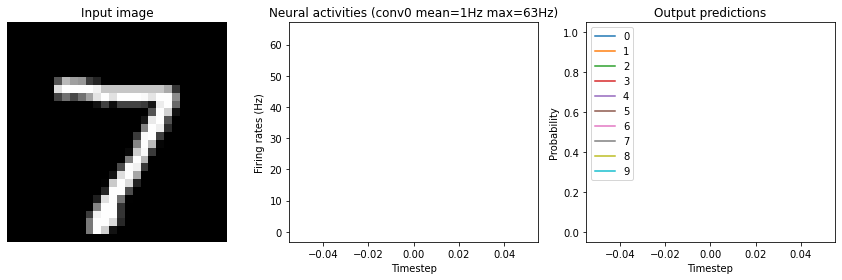

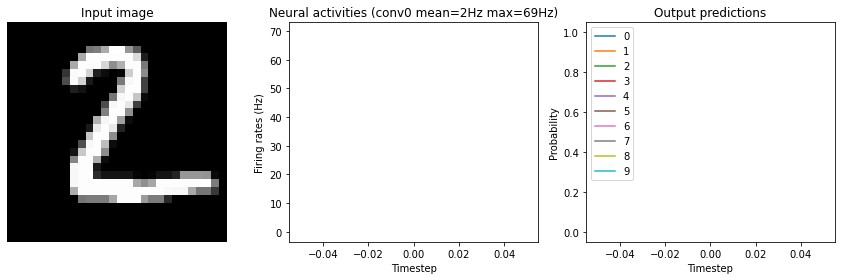

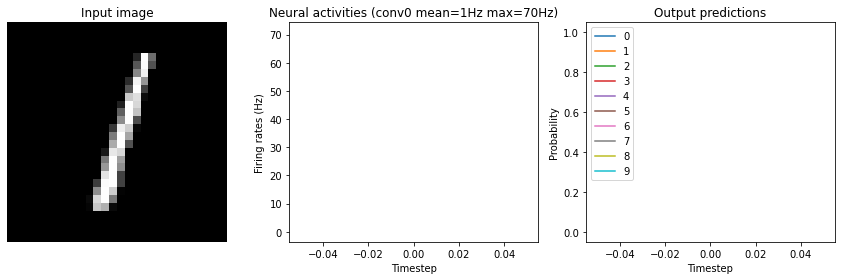

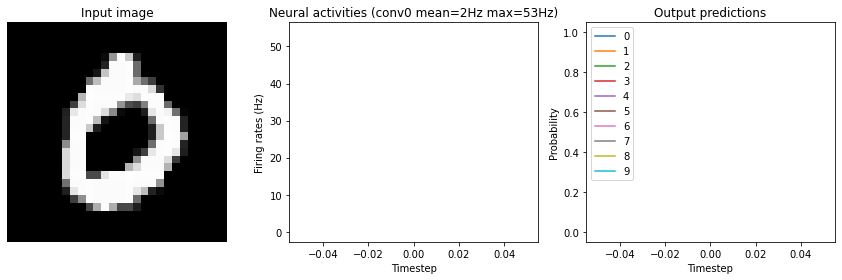

In [5]:
# run ANN
run_network(activation=nengo.RectifiedLinear(), n_steps=1)

Synapse=0.001
Test accuracy: 26.00%
Synapse=0.005
Test accuracy: 84.75%
Synapse=0.010
Test accuracy: 86.75%


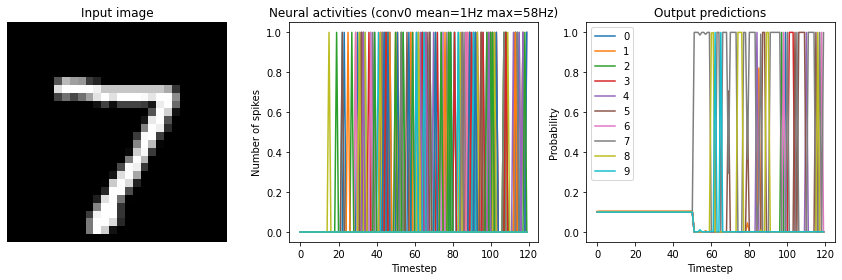

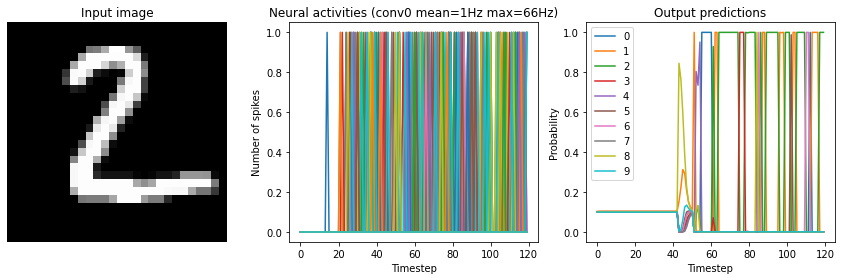

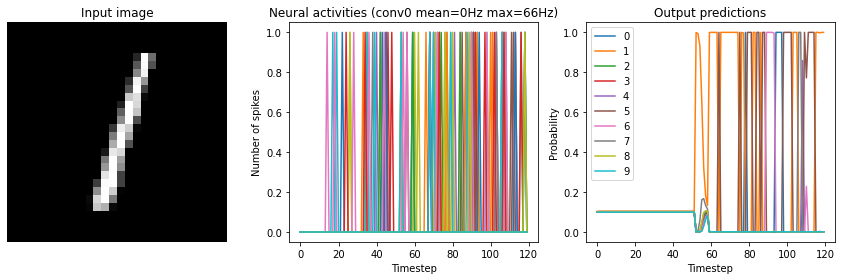

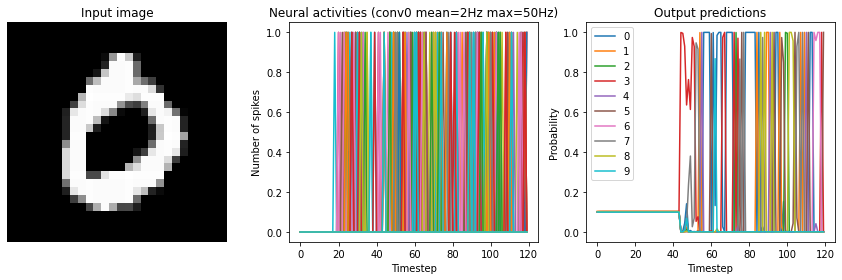

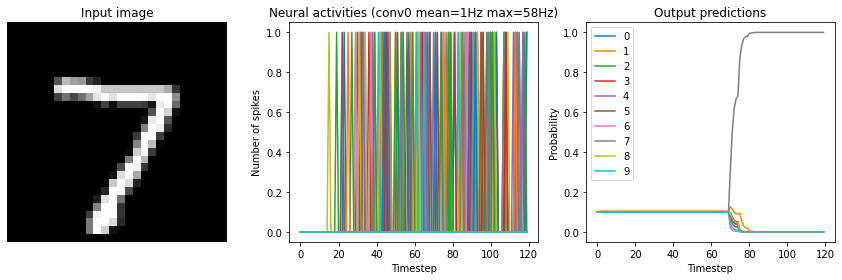

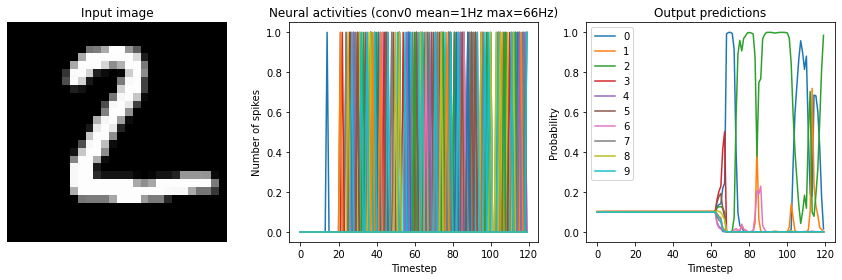

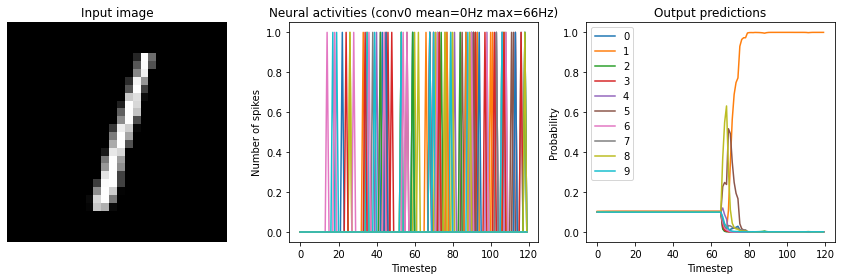

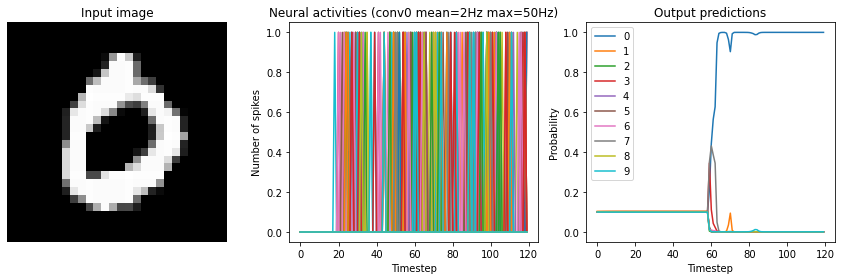

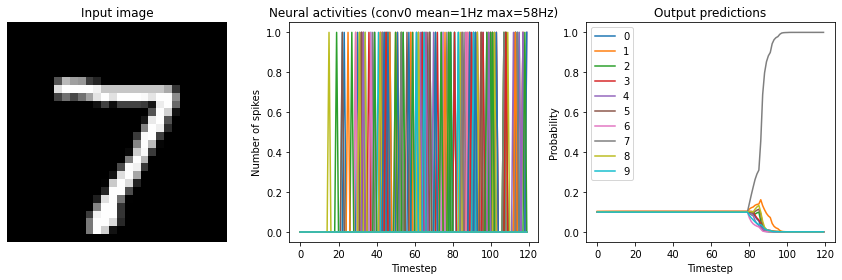

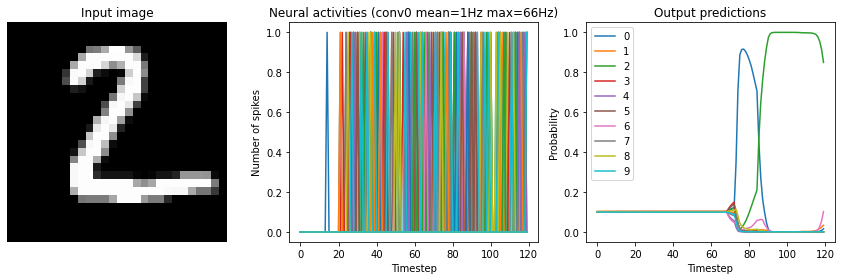

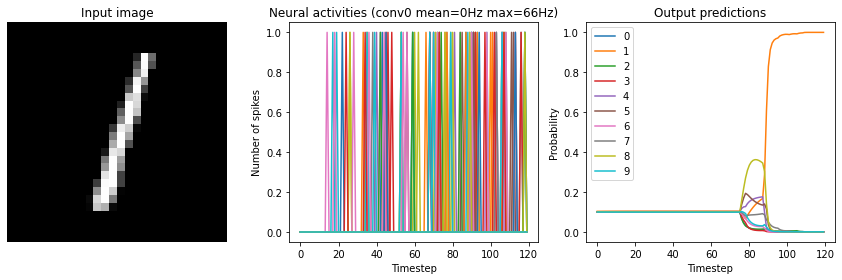

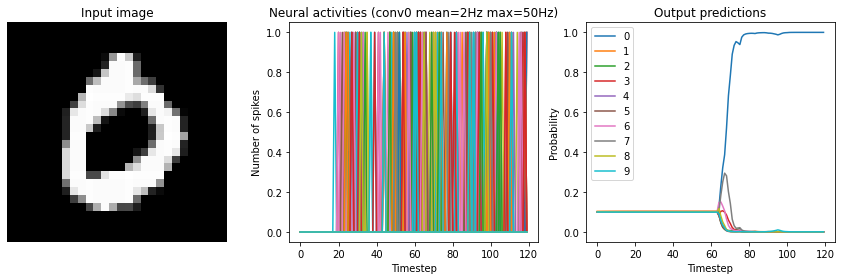

In [6]:
# run SNN

for s in [.001, .005, .01]:
    print("Synapse=%.3f" % s)
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=120,
        synapse=s,
    )
    plt.show()

scale: 2
Test accuracy: 14.25%
scale: 10
Test accuracy: 96.25%
scale: 20
Test accuracy: 97.50%


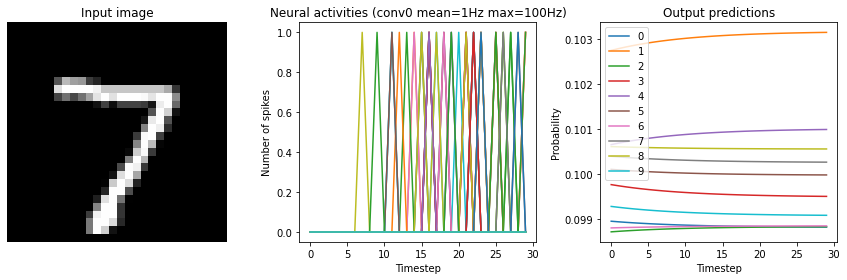

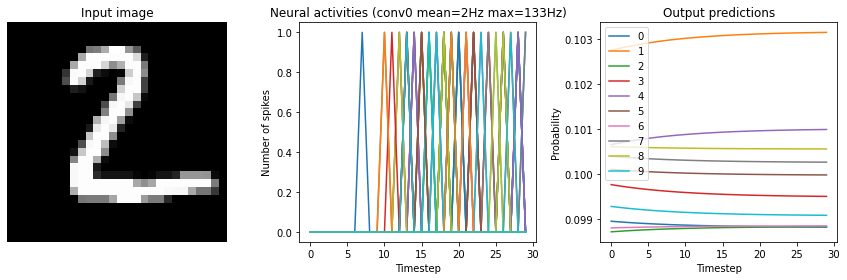

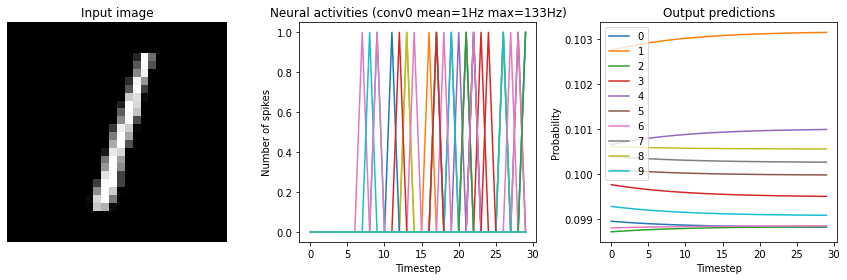

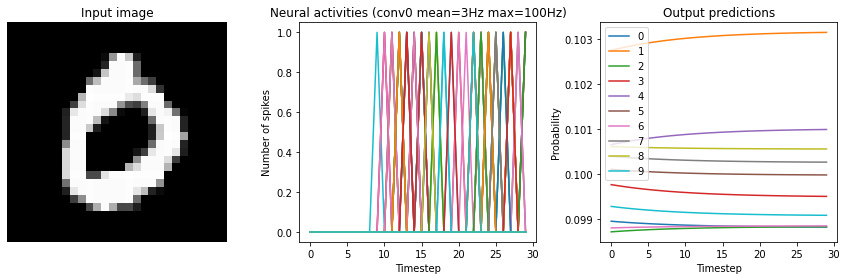

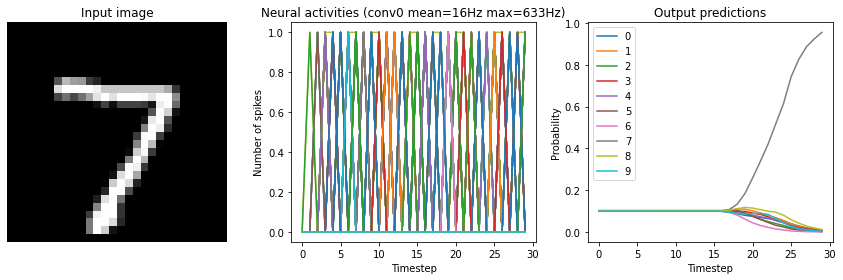

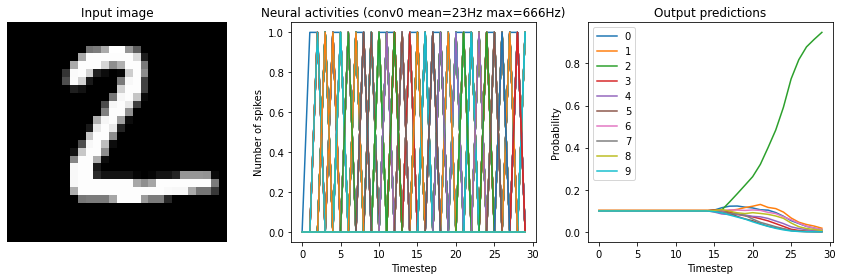

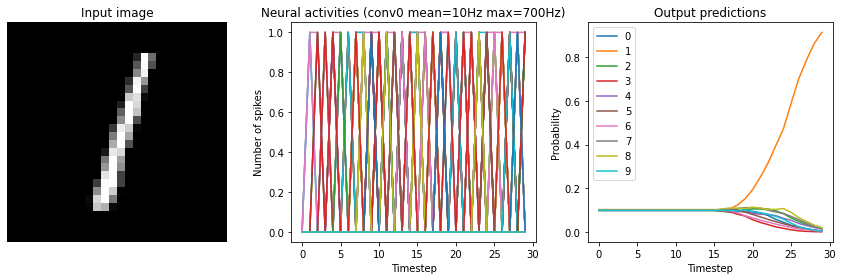

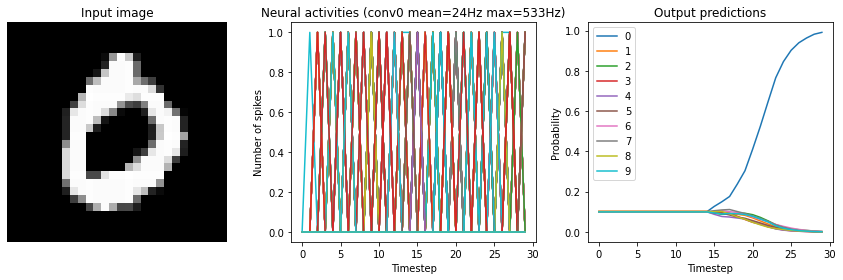

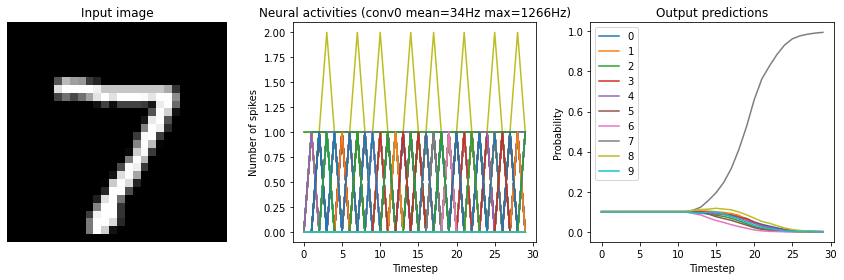

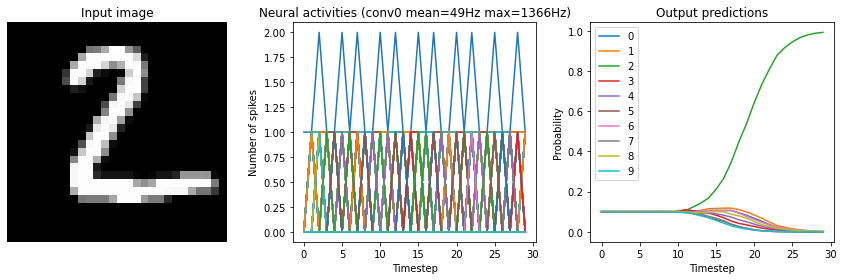

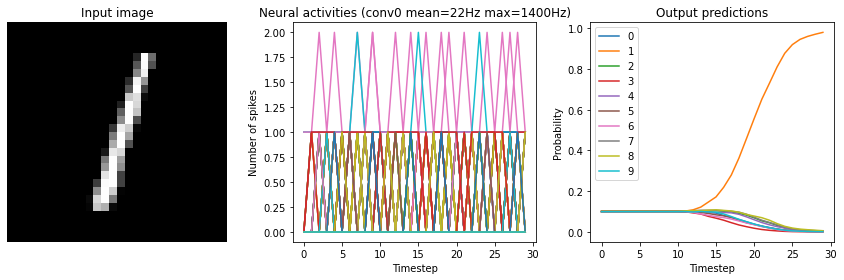

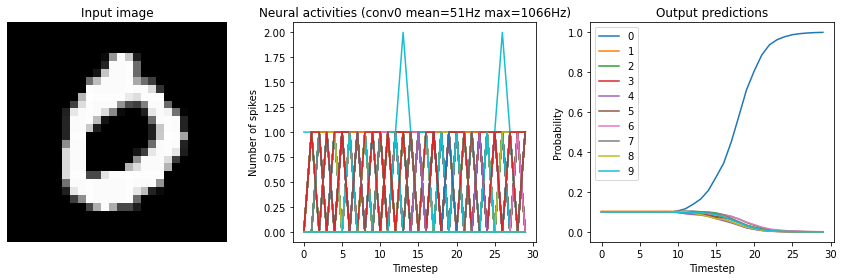

In [7]:
# run SNN with spike upscaling
for scale in [2, 10, 20]:
    print('scale:', scale)
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        scale_firing_rates=scale,
        synapse=0.01,
    )
    plt.show()

In [8]:
    target_hz = 250
    converter = nengo_dl.Converter(model)

    with converter.net:
        output_probe = converter.outputs[output_layer]
        conv1_probe = nengo.Probe(converter.layers[conv1])
        conv2_probe = nengo.Probe(converter.layers[conv2])

    with nengo_dl.Simulator(converter.net, minibatch_size=128) as simulator:
        simulator.compile(
            optimizer=tf.optimizers.RMSprop(.001),
            loss={
                output_probe: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                conv1_probe: tf.losses.mse,
                conv2_probe: tf.losses.mse,
            },
            loss_weights={
                output_probe: 1,
                conv1_probe: .001,
                conv2_probe: .001
            }
        )

        print('retraining with target frequency',target_hz,'Hz')
        simulator.fit(
            { converter.inputs[input_layer]: x_train },
            {
                output_probe: y_train,
                conv1_probe: np.ones((y_train.shape[0], 1, conv1_probe.size_in)) * target_hz,
                conv2_probe: np.ones((y_train.shape[0], 1, conv2_probe.size_in)) * target_hz
            },
            epochs=10
        )

        simulator.save_params(os.path.join(params_folder, 'keras_snn_regularized_params'))

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
retraining with target frequency 250 Hz
Epoch 1/10
468/468 [==============================] - 19s 41ms/step - loss: 103.1992 - probe_loss: 2.8781 - probe_1_loss: 50438.5117 - probe_2_loss: 49882.4258

C:\Users\itznu\anaconda3\envs\datascience-gpu\lib\site-packages\nengo_dl\simulator.py:1932: UserWarning: Number of elements in input data (60000) is not evenly divisible by Simulator.minibatch_size (128); input data will be truncated.
  % (data_batch, self.minibatch_size)


Test accuracy: 19.75%


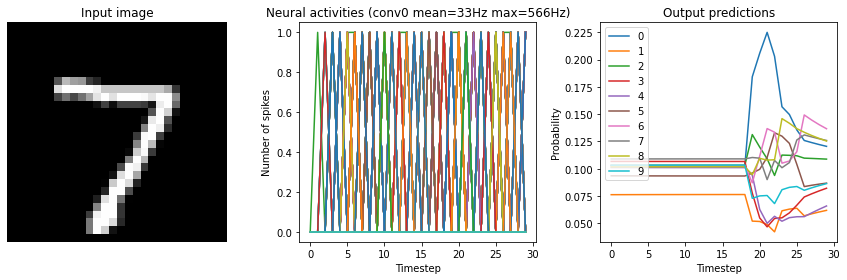

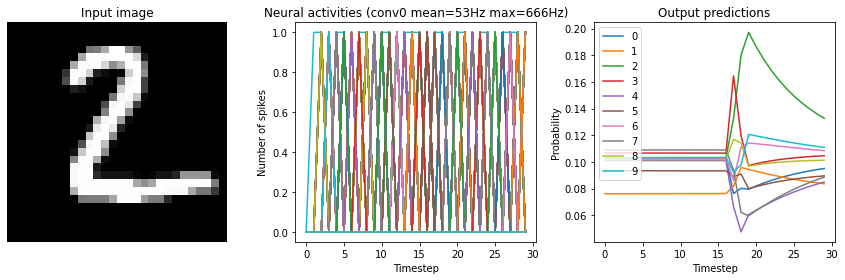

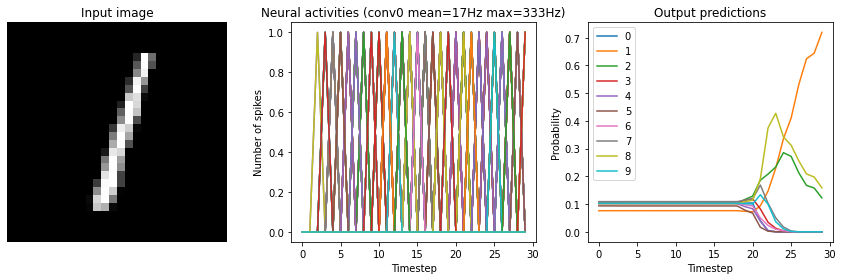

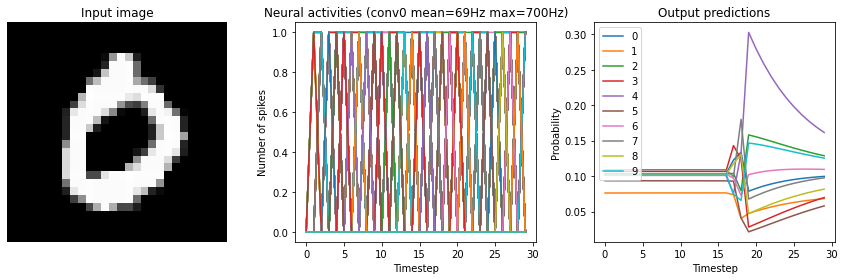

In [9]:
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file=os.path.join(params_folder, 'keras_snn_regularized_params'),
    synapse=.01
)
